# Heterogeneous flow

The best way to run `foxes` calculations on heterogeneous background flow fields is by providing them in `netCDF` format. They should contain the following coordinates:

- A state coordinate, e.g. `Time` (expected by default) or `state`, or similar
- A height coordinate, e.g. `height` (expected by default) or `h`, or similar
- A `y` coordinate, e.g. `UTMY` (expected by default) or `y`, or similar
- A `x` coordinate, e.g. `UTMX` (expected by default) or `x`, or similar

The file may contain any kind of `foxes` variables as data fields, e.g.:

- Wind speed data, e.g. `WS` (expected by default, if claimed as output variable), `ws` or similar
- Wind direction data, e.g. `WD` (expected by default, if claimed as output variable), `wd` or similar
- Turbulence intensity data, e.g. `TI` (expected by default, if claimed as output variable), `ti` or similar
- Air density data, e.g. `RHO` (expected by default, if claimed as output variable), `rho` or similar

All data must depend on the state coordinate, and may depend on the others.

These are the required imports for this example:

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import foxes
import foxes.variables as FV

One very simple example for `netCDF` type data is provided in the static data, under the name `wind_rotation.nc`. It contains two states, two heights, and simple 2 x 2 horizontal data that describes identical wind speeds at all four corner points associated with different wind direction values. It can be loaded as follows:

In [2]:
states = foxes.input.states.FieldDataNC(
    file_pattern="wind_rotation.nc",
    states_coord="state",
    x_coord="x",
    y_coord="y",
    h_coord="h",
    time_format=None,
    output_vars=[FV.WS, FV.WD, FV.TI, FV.RHO],
    var2ncvar={FV.WS: "ws", FV.WD: "wd"},
    fixed_vars={FV.RHO: 1.225, FV.TI: 0.1},
    pre_load=True,
    bounds_error=False,
)

Let's place a simple 3 x 3 grid wind farm inside the data domain, which is a rectangle between `(0, 0)` and `(2500, 2500)`:

In [3]:
farm = foxes.WindFarm()
foxes.input.farm_layout.add_grid(
    farm,
    xy_base=np.array([500.0, 500.0]),
    step_vectors=np.array([[500.0, 0], [0, 500.0]]),
    steps=(3, 3),
    turbine_models=["NREL5"],
    verbosity=0,
)

Again, we use the `NREL 5MW` turbine:

In [4]:
mbook = foxes.ModelBook()
mbook.turbine_types["NREL5"] = foxes.models.turbine_types.PCtFile(
    "NREL-5MW-D126-H90.csv"
)

The streamline following wakes are realized by selecting a `wake frame` that is an instance of `foxes.models.wake_frames.Streamlines`, e.g. the model `streamlines_100` in the model book. This model has a streamline step size of 100 m:

In [5]:
algo = foxes.algorithms.Downwind(
    mbook,
    farm,
    states=states,
    rotor_model="grid16",
    wake_models=["Jensen_linear_k007"],
    wake_frame="streamlines_100",
    partial_wakes_model="auto",
    chunks={FV.STATE: 1000, FV.POINT: 4000},
    verbosity=0,
)

We run the algorithm, once explicitely for calculating the wind farm data, and once implicitely when creating horizontal flow plots:

                       WD  AMB_REWS      REWS        AMB_P            P
state turbine                                                          
0     0        201.158092  7.491089  7.491089  1474.211367  1474.211367
      1        208.044994  7.673386  7.673386  1580.523022  1580.523022
      2        214.523994  7.960601  7.960601  1748.171047  1748.171047
      3        218.242345  6.867297  6.867297  1127.597810  1127.597810
      4        222.297880  7.283373  7.283373  1352.715530  1352.715530
      5        225.899315  7.731909  6.808657  1614.607085  1101.211997
      6        236.751304  6.932726  6.932726  1156.958672  1156.958672
      7        237.139685  7.375640  6.142662  1406.547918   801.751505
      8        237.484049  7.818854  6.381124  1665.347000   908.970303
1     0         20.311353  6.703701  5.149847  1054.871543   454.760942
      1         26.259090  6.995899  5.857833  1185.898485   690.639688
      2         31.676969  7.357075  7.357075  1396.122949  1396

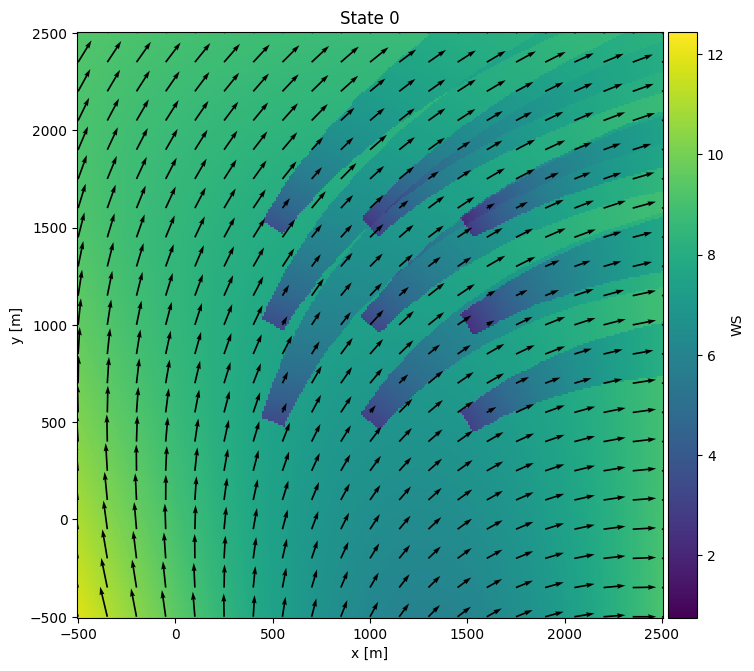

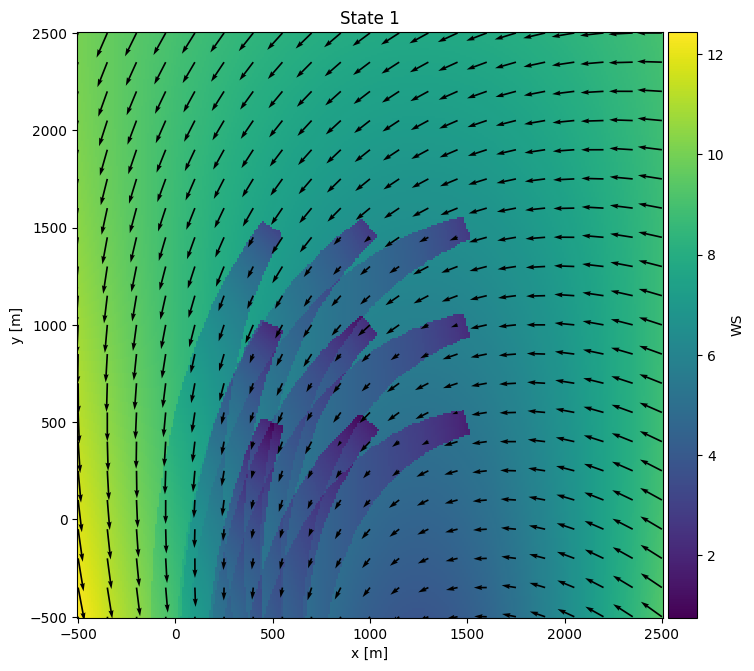

In [6]:
farm_results = algo.calc_farm()

fr = farm_results.to_dataframe()
print(fr[[FV.WD, FV.AMB_REWS, FV.REWS, FV.AMB_P, FV.P]])

o = foxes.output.FlowPlots2D(algo, farm_results)
for fig in o.gen_states_fig_horizontal(
    FV.WS,
    resolution=10,
    figsize=(8, 8),
    quiver_pars=dict(angles="xy", scale_units="xy", scale=0.07),
    quiver_n=15,
    xspace=1000,
    yspace=1000,
):
    plt.show()
    plt.close(fig)